In [ ]:
import os
import pathlib
import time
import zipfile
import tarfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

2024-05-08 07:07:07.262567: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 07:07:07.308003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 07:07:07.308047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 07:07:07.309177: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 07:07:07.316515: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
working_dir = pathlib.Path().absolute()
# Uncomment line below to debug if images don't show
#print(working_dir)
os.chdir(working_dir)


In [ ]:
# RUN THIS CELL

# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

print(f"tensorflow version {tf.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

devices = tf.config.get_visible_devices()
print(f"All Devices: \n{devices}\n")
print(f"Available GPUs: \n{tf.config.list_logical_devices('GPU')}\n")

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

tf.random.set_seed(2266)

tensorflow version 2.15.0
Eager Execution Enabled: True

All Devices: 
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Available GPUs: 
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]



2024-05-08 07:07:10.622815: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 07:07:10.632936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 07:07:10.635907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

{0: 'Turdus merula', 1: 'Turdus philomelos', 2: 'Sylvia atricapilla', 3: 'Erithacus rubecula', 4: 'Fringilla coelebs', 5: 'Strix aluco', 6: 'Parus major', 7: 'Troglodytes troglodytes', 8: 'Phylloscopus collybita', 9: 'Loxia curvirostra'}


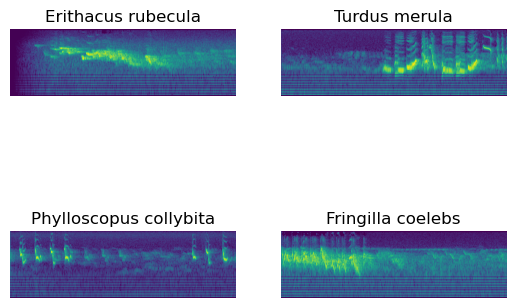

In [ ]:
test_dataset = tf.data.Dataset.load('data/tf_data/test_data')
train_dataset = tf.data.Dataset.load('data/tf_data/train_data')
val_dataset = tf.data.Dataset.load('data/tf_data/validation_data')

with open('data/tf_data/species_encoding.pkl', 'rb') as file:
    species_encoding = pickle.load(file)
species_encoding = {v: k for k, v in species_encoding.items()}
print(species_encoding)

fig, axs = plt.subplots(2,2)
for ax, img, label in [(a, *b) for a, b in zip(axs.ravel(), train_dataset.take(4))]:
    ax.imshow(img)
    ax.axis(False)
    ax.set_title(f'{species_encoding.get(tf.where(tf.equal(label, 1))[0][0].numpy())}')

In [ ]:
def normalize_image(img):
    return tf.cast(img, tf.float32)/255.

def preprocess(img, label):
    normalized = normalize_image(img)
    stacked = tf.stack([normalized]*3, axis=-1)
    return stacked, label

train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Load pre-trained EfficientNetB0
# base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 431, 3))
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 431, 3))
x = base_model.output
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.35)(x)
x = Dense(512, activation='relu', kernel_regularizer=L2(0.001))(x)
x = Dropout(0.35)(x)
predictions = Dense(10, activation='softmax')(x)

# Creating the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 431, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 128, 431, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 128, 431, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 128, 431, 3)          0         ['normalization[0][0]']   

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
initial_epochs = 5
full_epochs = 15

base_model.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(epsilon=1e-08, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
head_history = model.fit(train_dataset, epochs=initial_epochs, validation_data=val_dataset)

base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5, epsilon=1e-08, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

full_model_history = model.fit(train_dataset, initial_epoch=initial_epochs, epochs=initial_epochs+full_epochs, validation_data=val_dataset, callbacks=[early_stopping, lr_scheduler])

Epoch 1/5


2024-05-08 07:07:23.340511: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-08 07:07:23.985861: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 07:07:24.532601: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-05-08 07:07:24.652418: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 07:07:25.963582: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff87d051700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 07:07:25.963627: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Cap

2303/2303 [==============================] - 208s 85ms/step - loss: 2.3699 - accuracy: 0.1711 - val_loss: 2.2244 - val_accuracy: 0.1595
Epoch 2/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2259 - accuracy: 0.1729 - val_loss: 2.2242 - val_accuracy: 0.1595
Epoch 3/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2246 - accuracy: 0.1736 - val_loss: 2.2238 - val_accuracy: 0.1595
Epoch 4/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2243 - accuracy: 0.1734 - val_loss: 2.2237 - val_accuracy: 0.1595
Epoch 5/5
2303/2303 [==============================] - 191s 83ms/step - loss: 2.2245 - accuracy: 0.1736 - val_loss: 2.2236 - val_accuracy: 0.1743
Epoch 6/20


2024-05-08 07:23:54.960683: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2303/2303 [==============================] - 718s 291ms/step - loss: 1.9651 - accuracy: 0.1837 - val_loss: 2.2479 - val_accuracy: 0.1595 - lr: 5.0000e-05
Epoch 7/20
2303/2303 [==============================] - 672s 292ms/step - loss: 1.8521 - accuracy: 0.2259 - val_loss: 2.2543 - val_accuracy: 0.1595 - lr: 5.0000e-05
Epoch 8/20
2303/2303 [==============================] - 671s 291ms/step - loss: 1.7693 - accuracy: 0.2730 - val_loss: 185.7931 - val_accuracy: 0.1743 - lr: 5.0000e-05
Epoch 9/20
2303/2303 [==============================] - 671s 292ms/step - loss: 1.6753 - accuracy: 0.3390 - val_loss: 2.1852 - val_accuracy: 0.1956 - lr: 5.0000e-05
Epoch 10/20
2303/2303 [==============================] - 671s 291ms/step - loss: 1.5701 - accuracy: 0.3702 - val_loss: 2.3783 - val_accuracy: 0.0983 - lr: 5.0000e-05
Epoch 11/20
2303/2303 [==============================] - 671s 292ms/step - loss: 1.5145 - accuracy: 0.4161 - val_loss: 1.9899 - val_accuracy: 0.2765 - lr: 5.0000e-05
Epoch 12/20
2303/

In [ ]:
def plot_hist(model, title=None):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    axs[0].plot(model.history['loss'], label='train')
    axs[0].plot(model.history['val_loss'], label='val')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('CE Loss')
    axs[0].set_title('Loss')
    axs[0].legend()
    axs[1].plot(model.history['accuracy'], label='train')
    axs[1].plot(model.history['val_accuracy'], label='val')
    axs[1].set_title('Accuracy')
    axs[1].legend();
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('ACC')
    plt.suptitle(title)

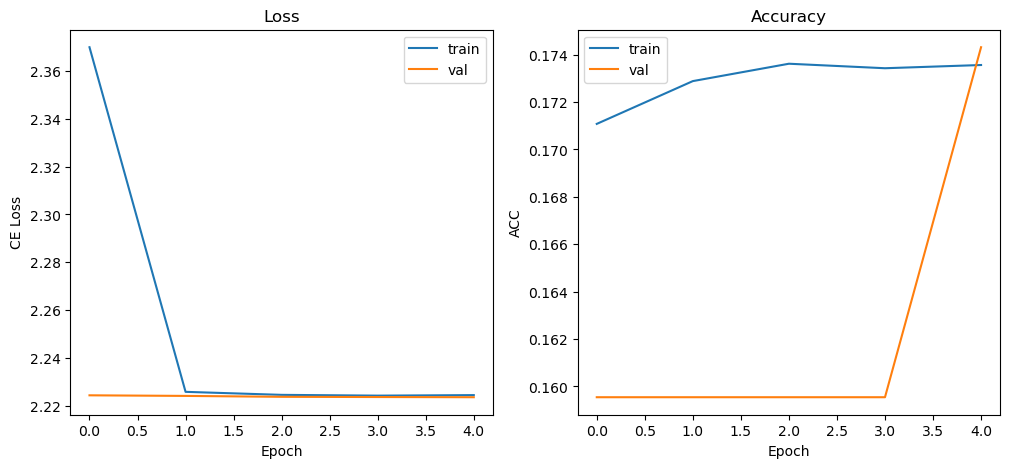

In [ ]:
plot_hist(head_history)

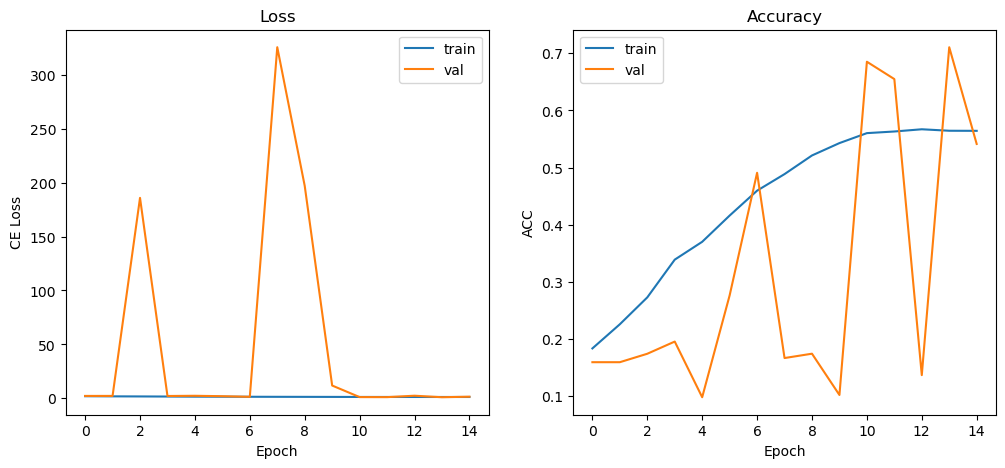

In [ ]:
plot_hist(full_model_history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

720/720 [==============================] - 45s 62ms/step - loss: 1.4301 - accuracy: 0.5455
Test Loss: 1.4300833940505981
Test Accuracy: 0.5455137491226196


In [ ]:
model.save_weights('fine_tuned.h5')

NameError: name 'history' is not defined